In [349]:
import logging
logger = logging.getLogger()
for handler in logger.handlers:
    handler.level = logging.WARNING
handler = logging.FileHandler(filename='eit.log', mode='w')
handler.level = logging.INFO
logger.level = logging.INFO
logger.addHandler(handler)

In [350]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import sympy as sp
sp.init_printing()
import bayesian_pdes as bpdes
from bayesian_pdes.problems import eit
import matplotlib
from mcmc import pcn
%load_ext mcmc
%mcmc notebook
import scipy
from scipy import stats
import tables
import os
import bayesian_design as bd
#import gpanim
#matplotlib.rc('text', usetex=True)
#matplotlib.rcParams['text.latex.unicode'] = True

The mcmc extension is already loaded. To reload it, use:
  %reload_ext mcmc


In [351]:
bayesian_approach = True
use_real_data = False
noise_variance = 10.0
n_pts = 40
dest_name = '/Users/benorn/samples_bayes_ed_n={}_3.h5'.format(n_pts)
#seed_name = 'sim_data/truth2.txt'
seed_name = '/Users/benorn/samples_bayes_ed_n={}_2.h5'.format(n_pts)

In [352]:
seed = 124
np.random.seed(seed)

In [353]:
x_1,x_2,y_1,y_2 = sp.symbols('x_1 x_2 y_1 y_2')

In [354]:
# load in observational data
current_file = np.loadtxt('RPI_2d_chest_phantom_data/ssout1.dat')
if use_real_data:
    voltage_file = np.loadtxt('RPI_2d_chest_phantom_data/ACT2000r.txt')
    #voltage_file = np.loadtxt('RPI_2d_chest_phantom_data/ACT2006r.txt') # empty tank
else:
    voltage_file = np.loadtxt('sim_data/voltages2.txt')


experiments = []
for i in range(len(current_file) / 32):
    this_currents = current_file[32*i:32*(i+1)]
    this_voltages = voltage_file[32*i+1:32*(i+1)+1]
    #this_voltages = np.random.normal(this_voltages, noise_variance)
    experiments.append((this_currents.reshape((32,1)), this_voltages.reshape((32,1))))

In [355]:
def cart2pol(points):
    x = points[:,0]
    y = points[:,1]
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return np.column_stack([rho, phi])

def pol2cart(points):
    rho = points[:,0]
    phi = points[:,1]
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return np.column_stack([x, y])

# Set Up Grid for $\kappa$

In [356]:
# there are 32 evenly spaced electrodes between 0 and 2\pi
# the electrodes go counter-clockwise from the +x axis and finish at x=1, y=0
electrodes = np.linspace(0, 2*np.pi, 33)[1:-1]
electrodes = np.append(electrodes,0)
electrode_x = np.cos(electrodes)
electrode_y = np.sin(electrodes)

bdy = np.c_[electrode_x, electrode_y]

In [357]:
def construct_shell(radii):
    r_spacing = radii[1] - radii[0]
    coords = [np.array([[0.,0.]])]
    for r in radii:
        # at each 'shell' we want a roughly equal number of theta around the diameter.
        # each theta should be about r_spacing apart
        n_theta = np.round(2*np.pi*r / r_spacing)
        thetas = np.linspace(0, 2*np.pi, n_theta+1)[:-1]
        x = np.cos(thetas)
        y = np.sin(thetas)
        coords.append(r*np.c_[x,y])
    coords = np.concatenate(coords)
    return coords

In [358]:
# we also need a few interior points
radii = np.linspace(0,1,11)[1:-1]
field_interior = construct_shell(radii)

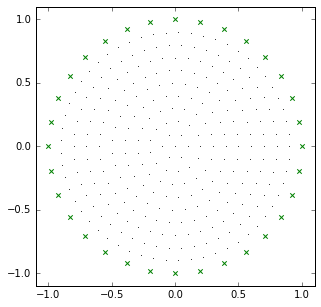

In [359]:
plt.figure(figsize=(5,5))
plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1);
plt.scatter(bdy[:,0], bdy[:,1], marker='x', c='green')
plt.scatter(field_interior[:,0], field_interior[:,1], linewidth=0, c='black', s=1)

In [360]:
field_pts = np.r_[field_interior, bdy]
n_field = len(field_pts)

def vec_to_kappas(vec):
    return vec[:n_field, None], vec[n_field:2*n_field, None], vec[2*n_field:, None]

In [361]:
print len(field_pts)

316


# Initial Design

In [362]:
design_radii = np.random.uniform(0,1,n_pts)
design_theta = np.random.uniform(-np.pi, np.pi, n_pts)
initial_design = pol2cart(np.column_stack([design_radii, design_theta]))

40


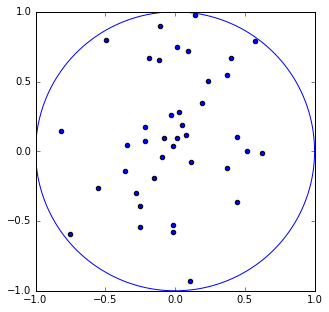

In [363]:
plt.figure(figsize=(5,5))
plt.scatter(initial_design[:,0], initial_design[:,1])
circ_r = np.ones(1000)
circ_theta = np.linspace(-np.pi, np.pi, 1000)
circ_cart = pol2cart(np.column_stack([circ_r, circ_theta]))
plt.plot(circ_cart[:,0], circ_cart[:,1])
plt.xlim([-1,1]); plt.ylim([-1,1]);
print(len(initial_design))

# Construct the Model

In [364]:
x_1, x_2, y_1, y_2 = sp.symbols('x_1 x_2 y_1 y_2')
length_scale = sp.Symbol('sigma')
k_sqexp = sp.exp(-((x_1-y_1)**2 + (x_2-y_2)**2) / (2*length_scale**2))
eit_sys_factory = eit.EITFactory(k_sqexp, [x_1, x_2], [y_1, y_2], [length_scale], compile_mode='cython', verbosity=0)

In [365]:
def plot_conductivity(thetas):
    sig_expr = get_c(x_1, x_2).subs({t: v for t,v in zip(ts, thetas)})
    sigma_field = sp.lambdify([x_1, x_2], sig_expr)
    res = np.vectorize(sigma_field)(test_x, test_y)
    plot_circle(test_x, test_y, res)
    
def plot_circle(x, y, values, design=None):
    plt.tripcolor(x.ravel(), y.ravel(), values.ravel())
    #colors = plt.contourf(test_x, test_y, mu_shaped,  250)
    plt.colorbar()
    if design is not None:
        plt.scatter(design[:,0], design[:,1],  marker='x', c='black', s=50, label='Interior Points')
    plt.legend()
    plt.axis('scaled')
    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1);
def plot_stimulations(x, y, stims, design=None, n_cols=4):
    n_images = stims.shape[0]
    n_rows = int(np.ceil(n_images * 1./ n_cols))
    print(n_rows, n_cols)
    plt.figure(figsize=(n_cols*4, n_rows*4))
    for ix in range(n_images):
        plt.subplot(n_rows, n_cols, ix+1)
        plot_circle(x, y, stims[ix,:], design)

In [366]:
# now need to construct the thingy we are proposing over.
# Put a basis function at each point in the domain and iterate over them

# jointly proposing over the function and its derivatives wrt x and y.
# ironically constructing this is very similar to constructing our kernel matrix
Identity = lambda k: k
d1 = lambda k: k.diff(x_1)
d2 = lambda k: k.diff(x_2)
d1_bar = lambda k: k.diff(y_1)
d2_bar = lambda k: k.diff(y_2)

proposal_op_cache = bpdes.operator_compilation.compile_sympy([Identity, d1, d2], 
                                                             [Identity, d1_bar, d2_bar], 
                                                             k_sqexp, 
                                                             [[x_1, x_2], [y_1, y_2], [length_scale]],
                                                             mode='cython'
                                                            )


In [367]:
regress_length_scale = np.array([0.1])

In [368]:
regress_kern = proposal_op_cache[()]
regress_mat = regress_kern(field_pts, field_pts, regress_length_scale)
inv_regress_mat = np.linalg.inv(regress_mat)

In [369]:
def calc_interior_dot_mat(interior_points):
    regress_kern = proposal_op_cache[()]
    left_multiplier = regress_kern(interior_points, field_pts, regress_length_scale)
    return np.dot(left_multiplier, inv_regress_mat)

def calc_bdy_dot_mat(bdy_points):
    regress_kern = proposal_op_cache[()]
    left_multiplier = regress_kern(bdy_points, field_pts, regress_length_scale)
    return np.dot(left_multiplier, inv_regress_mat)

In [370]:
# is there a units issue with normalising voltage here?
true_x = bdy
if seed_name is not None:
    ext = os.path.splitext(seed_name)[1]
    if ext == '.h5':
        with tables.open_file(seed_name) as tab:
            tmp = tab.get_node('/samples')
            kappa_0 = tmp[-1, :]
    elif ext == '.txt':
        tmp = np.loadtxt(seed_name)
        kappa_0 = tmp[:,2]
else:
    kappa_0 = np.zeros((n_field*3, 1))
    
currents = [e[0] for e in experiments]
voltages = [e[1] for e in experiments]
#volt_mean = np.asarray(voltages).mean()
#volt_std = np.asarray(voltages).std()
volt_mean = 0.
volt_std = 1.

In [371]:
def get_posterior(proposal, length_scale, interior_points, boundary_points, use_cache=False,
                  interior_dot_mat=None, boundary_dot_mat=None, debug=False):
    sim_kappa, sim_kappa_x, sim_kappa_y = vec_to_kappas(proposal)
        
    # use current design if interior points are none
    if interior_dot_mat is None:
        interior_dot_mat = calc_interior_dot_mat(interior_points)
    if boundary_dot_mat is None:
        boundary_dot_mat = calc_bdy_dot_mat(boundary_points)
    kappa_int = interior_dot_mat.dot(sim_kappa).ravel()
    kappa_bdy = boundary_dot_mat.dot(sim_kappa).ravel()
    kappa_x = interior_dot_mat.dot(sim_kappa_x).ravel()
    kappa_y = interior_dot_mat.dot(sim_kappa_y).ravel()

    # these should all be satisfied if the interior design matches the simulation field
    if debug and np.all(interior_points == field_interior):
        np.testing.assert_almost_equal(kappa_int, sim_kappa[:len(field_interior), 0])
        np.testing.assert_almost_equal(kappa_bdy, sim_kappa[len(field_interior):, 0])
        np.testing.assert_almost_equal(kappa_x, sim_kappa_x[:len(field_interior), 0])
        np.testing.assert_almost_equal(kappa_y, sim_kappa_y[:len(field_interior), 0])
    oc = eit_sys_factory.get_operator_system(kappa_int, kappa_bdy, kappa_x, kappa_y, use_cache)
    ops = oc.operators
    ops_bar = oc.operators_bar
    # always observing the same boundary points
    obs = [(interior_points, None), (bdy, None)]

    posterior = bpdes.collocate(ops, ops_bar, None, None, obs, oc, fun_args=length_scale)
    return posterior

In [372]:
class EITState(object):
    def __init__(self, design, length_scale, regress_op_cache, debug=False):
        self.design = design
        self.length_scale = length_scale
        self.regress_op_cache = regress_op_cache
        
        self.interior_dot_mat = calc_interior_dot_mat(design)
        self.boundary_dot_mat = calc_bdy_dot_mat(bdy)
        
        self.debug = debug
        
    def potential(self, proposal, use_cache=True):
        # potential is the negative log-likelihood
        return -self.log_likelihood(proposal, use_cache)
        
    def get_posterior(self, proposal, use_cache=False):
        return get_posterior(proposal, self.length_scale, self.design, bdy, use_cache, 
                             self.interior_dot_mat, self.boundary_dot_mat, self.debug)
    
    def solve_forward(self, proposal, locations, use_cache=False):
        posterior = self.get_posterior(proposal, use_cache)
        
        mu_mult, cov = posterior.no_obs_posterior(locations)
        
        interior_obs = np.zeros((self.design.shape[0], 1))
        res = np.empty((len(currents), mu_mult.shape[0]))
        for ix, current in enumerate(currents):
            g = np.concatenate([interior_obs, current])
            mu = mu_mult.dot(g)
            res[ix, :] = mu.ravel()
        return res, cov
            
    
    def log_likelihood(self, proposal, use_cache=True):
        mus, cov = self.solve_forward(proposal, true_x, use_cache=use_cache)
        cov = noise_variance**2*cov
        like_error = noise_variance**2*np.eye(cov.shape[0])
        cov_with_error = cov + like_error
        
        if self.debug:
            print('covariance vs. likelihood trace: {:.4e}, {:.4e}'.format(np.trace(cov), np.trace(like_error)))
        if bayesian_approach:
            like_dist = stats.multivariate_normal(np.zeros(cov.shape[0]), cov_with_error, False)
        else:
            like_dist = stats.multivariate_normal(np.zeros(cov.shape[0]), like_error, False)

        ret = 0
        try:
            for ix, voltage in enumerate(voltages):
                true_u = voltage.reshape((len(voltage), 1))
                mu = mus[ix,:]

                this_lik = like_dist.logpdf(true_u.ravel() - mu.ravel())
                ret += this_lik
        except Exception as ex:
            if self.debug:
                print(ex)
            return -np.inf
        return ret

# Experiment Design

In [373]:
ls_ml = np.array([0.1])

In [374]:
test_radii = np.linspace(0, 1, 5)[1:-1]
design_test = construct_shell(test_radii)

In [375]:
design_ls = np.array([0.1])


def get_cov_polar(proposal, length_scale, points, debug=False):
    if points.shape == (2,):
        points = points.reshape((1,2))
    cart_points = pol2cart(points)
    posterior = get_posterior(proposal, length_scale, cart_points, bdy, use_cache=False, debug=debug)
    cov = posterior.diagonal_covariance(design_test)
    return cov
    
def get_cov(points):
    return get_cov_polar(kappa_0, design_ls, points)
bdy_epsilon = 0.01
get_optimizer_bounds = lambda p: [(bdy_epsilon, 1.-bdy_epsilon), (-np.pi + bdy_epsilon, np.pi-bdy_epsilon)]

# todo: need to couch the problem in polar coordinates so that we can just work in a square instead of a
# circle. In a circle the optimizer will struggle.
optimizer = bd.optimizers.gpyopt_optimizer(get_optimizer_bounds)
initial_design_polar = cart2pol(initial_design.copy())

loss = bd.a_optimality(get_cov)
file_name = 'eit_designs/n={}.npy'.format(n_pts)
if not os.path.exists(file_name):
    new_design = bd.ace(initial_design_polar, 
                        5, 
                        20, 
                        loss, 
                        optimizer,
                        debug=1
                       )
    np.save(file_name, new_design)
else:
    new_design = np.load(file_name)
new_design = pol2cart(new_design)

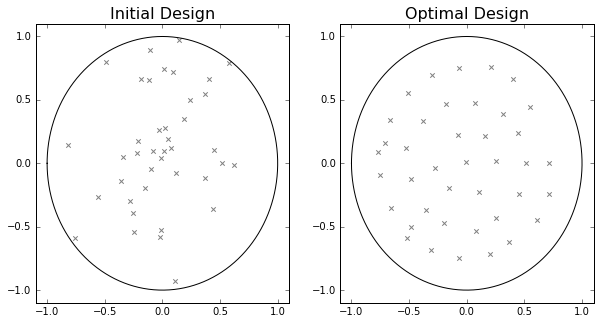

In [376]:
def scatter_design(design):
    plt.scatter(design[:,0], design[:,1], marker='x', c='gray')
    plt.plot(circ_cart[:,0], circ_cart[:,1], c='black')
    plt.xlim(-1.1, 1.1); plt.ylim(-1.1, 1.1);
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title('Initial Design', fontsize=16)
scatter_design(initial_design)
plt.subplot(122)
plt.title('Optimal Design', fontsize=16)
scatter_design(new_design)
plt.savefig('figures/eit_designs_{}.pdf'.format(n_pts), transparent=True, bbox_inches=0)

# MCMC

In [377]:
state = EITState(new_design, ls_ml, proposal_op_cache)
def potential(ls):
    state.length_scale = np.array([ls])
    return -state.log_likelihood(kappa_0, False)
    
tmp = scipy.optimize.minimize(np.vectorize(potential), 0.1, method='Nelder-Mead')
ls_ml = tmp.x
print(ls_ml)

[ 0.17072981]


In [378]:
test_state = EITState(new_design, ls_ml, proposal_op_cache, debug=True)
test_state.log_likelihood(kappa_0)

covariance vs. likelihood trace: 2.9582e+03, 3.2000e+03


In [379]:
propose_ls = np.array([0.1])
proposal_obs = [
    (field_pts, None),
    (field_pts, None),
    (field_pts, None),
]
proposal_caching_op_cache = bpdes.operator_compilation.CachingOpCache(proposal_op_cache)
kern_mat = bpdes.collocation.calc_LLbar([Identity, d1, d2], 
                                        [Identity, d1_bar, d2_bar], 
                                        proposal_obs, 
                                        proposal_op_cache, 
                                        fun_args=propose_ls
                                       )

In [380]:
mcmc_state = EITState(new_design, ls_ml, proposal_op_cache)

In [ ]:
n_iter = 500000
storage_dump_interval = int(1e3)
beta = 1e-4
proposal = pcn.proposal(beta, kern_mat)

In [ ]:
from mcmc import storage
with storage.DiskBackedStorage((storage_dump_interval, n_field*3), dest_name) as st:
    
    _, acceptances = pcn.pCN(n_iter, proposal, mcmc_state.potential, kappa_0, storage=st)

import tables
with tables.open_file(dest_name, 'a') as tab:
    tab.create_group('/', 'params')
    tab.create_array('/params', 'beta', obj=beta)
    tab.create_array('/params', 'length_scale', obj=ls_ml)
    tab.create_array('/params', 'proposal_matrix', obj=kern_mat)
    tab.create_array('/params', 'locations', obj=field_pts)
    tab.create_array('/', 'acceptances', acceptances)

In [ ]:
import tables
with tables.open_file(dest_name) as tab:
    tmp = tab.get_node('/samples')
    thinned_burned = tmp[::10]

In [ ]:
actual = np.mean(thinned_burned, axis=0)
#actual = thinned_burned[-1,:]

plot_circle(field_pts[:,0], field_pts[:,1], np.exp(actual[:len(field_pts)]))

# Dummy diffusivity field

In [ ]:
model_ls = np.array([0.1])

In [ ]:
true_kappa = sp.exp(-((x_1 - 0.4)**2 + (x_2 - 0.4)**2) / (2*0.2**2)) + sp.exp(-((x_1 + 0.4)**2 + (x_2 + 0.4)**2) / (2*0.2**2))
true_kappa_dx1 = true_kappa.diff(x_1)
true_kappa_dx2 = true_kappa.diff(x_2)

true_kappa_fun = np.vectorize(sp.lambdify([x_1, x_2], true_kappa))
true_kappa_dx1_fun = np.vectorize(sp.lambdify([x_1, x_2], true_kappa_dx1))
true_kappa_dx2_fun = np.vectorize(sp.lambdify([x_1, x_2], true_kappa_dx2))

In [ ]:
true_k_int = np.log(true_kappa_fun(field_interior[:,0], field_interior[:,1]))
true_k_bdy = np.log(true_kappa_fun(bdy[:,0], bdy[:,1]))
true_k_x = true_kappa_dx1_fun(field_pts[:,0], field_pts[:,1])
true_k_y = true_kappa_dx2_fun(field_pts[:,0], field_pts[:,1])
true_fun = np.r_[true_k_int, true_k_bdy, true_k_x, true_k_y]

In [ ]:
plt.figure(figsize=(8,8))
true_k = np.r_[true_k_int, true_k_bdy]
plot_circle(field_pts[:,0], field_pts[:,1], np.exp(true_k), field_interior)
plt.savefig('figures/eit_diffusivity.pdf', transparent=True, bbox_inches=0)

In [ ]:
true_currents = [e[0] for e in experiments]
true_voltages = []
oc = eit_sys_factory.get_operator_system(true_k_int, true_k_bdy, true_k_x[:len(field_interior)], true_k_x[:len(field_interior)])
model_obs = [
    (field_interior, None),
    (bdy, None)
]
posterior = bpdes.collocate(oc.operators, oc.operators_bar, None, None, model_obs, oc, fun_args=model_ls)
mu_mult, cov = posterior.no_obs_posterior(true_x)
mu_mult_plt, _ = posterior.no_obs_posterior(field_pts)
model_int_obs = np.zeros((field_interior.shape[0], 1))
model_mus = np.empty((len(true_currents), len(field_pts)))

for ix, c in enumerate(true_currents):
    g = np.concatenate([model_int_obs, c])
    mu = mu_mult.dot(g)
    model_mus[ix, :] = mu_mult_plt.dot(g).ravel()
    true_voltages.append(mu)

In [ ]:
cov_with_error = cov + noise_variance**2*np.eye(cov.shape[0])
model_like_dist = scipy.stats.multivariate_normal(np.zeros(cov_with_error.shape[0]), cov_with_error)

log_like = mu.shape[0] * model_like_dist.logpdf(np.zeros(cov_with_error.shape[0]))
print(log_like)

In [ ]:
plot_stimulations(field_pts[:,0], field_pts[:,1], model_mus)

In [ ]:
voltage_file = np.concatenate([np.array([[0]])] + true_voltages)
#np.savetxt('sim_data/voltages2.txt', voltage_file)
#np.savetxt('sim_data/truth2.txt', np.c_[np.r_[field_pts, field_pts, field_pts], true_fun[:,None]])